In [2]:
import pandas as pd
import nibabel as nib
from nibabel import freesurfer as fs
import neuromaps
from neuromaps.datasets import fetch_atlas, fetch_annotation
from neuromaps import transforms
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%load_ext rpy2.ipython

In [3]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(ggnewscale)
    library(ggsegGlasser)
    library(ggseg)
    library(hexbin)
    library(see)
    library(tidyverse)
    theme_set(theme_cowplot())
})

options(dplyr.width = Inf)

In addition: Warning message:
package ‘ggnewscale’ was built under R version 4.3.3 


## Load Glasser parcellation for right hemisphere

In [4]:
# Read in Glasser 180 right hemisphere
glasser180_right_file = "/Users/abry4213/data/neuroimaging_atlases/surfaces/Glasser_2016/fsaverage/rh.HCP-MMP1.annot"
glasser180_right_vertices, glasser180_right_ctab, glasser180_right_names = fs.read_annot(glasser180_right_file)

glasser180_right_vertices = glasser180_right_vertices.byteswap().newbyteorder()
glasser180_right_ctab = glasser180_right_ctab.byteswap().newbyteorder()
glasser180_right_names = [name.decode() for name in glasser180_right_names]

# Create Glasser 180 right hemi lookup table
glasser180_right_LUT = pd.DataFrame({'index': np.arange(0, len(glasser180_right_names)), 'Glasser_RH_ROI': glasser180_right_names})

# Convert glasser array to dataframe
glasser180_right_df = pd.DataFrame({'index': glasser180_right_vertices, 'vertex_number': np.arange(0, len(glasser180_right_vertices))})
glasser180_right_df['Glasser_RH_ROI'] = glasser180_right_df['index'].map(glasser180_right_LUT.set_index('index')['Glasser_RH_ROI'])

# Drop index
glasser180_right_df = glasser180_right_df.drop(columns=['index'])

## Load overlapping community detection algorithm (OCDA) modules

In [5]:
# Read in OCDA modules
ocda_modules_glasser180_right = pd.read_csv("/Users/abry4213/github/OverlappingCommunityDetection_HCP/Results/table_of_modules_AF_renamed.csv")
ocda_modules_glasser180_right.columns = ["Glasser_RH_ROI", "module", "overlapping"]

# Load module orders
module_orders = pd.read_csv("module_order.csv")

In [6]:
%%R -i ocda_modules_glasser180_right,module_orders -o ocda_modules_glasser180_right

# Tidy data
ocda_modules_glasser180_right <- ocda_modules_glasser180_right %>% 
  mutate(module = factor(module, levels = module_orders$Module))%>% 
  filter(module != "Unassigned")

## Load Yeo 2011 7-network parcellation

In [7]:
yeo7_right_file = "/Users/abry4213/data/neuroimaging_atlases/surfaces/Yeo_JNeurophysiol11_FreeSurfer/fsaverage/label/rh.Yeo2011_7Networks_N1000.annot"
yeo7_right_vertices, yeo7_right_ctab, yeo7_right_names = fs.read_annot(yeo7_right_file)

yeo7_right_vertices = yeo7_right_vertices.byteswap().newbyteorder()
yeo7_right_ctab = yeo7_right_ctab.byteswap().newbyteorder()
yeo7_right_names = [name.decode() for name in yeo7_right_names]

# Create Yeo 7 right hemi lookup table
yeo7_right_LUT = pd.read_csv("yeo7_lookup.csv")

# Convert yeo17 array to dataframe
yeo7_right_df = pd.DataFrame({'index': yeo7_right_vertices, 'vertex_number': np.arange(0, len(yeo7_right_vertices))})
yeo7_right_df['Yeo7_RH_ROI'] = yeo7_right_df['index'].map(yeo7_right_LUT.set_index('index')['Yeo7_RH_ROI'])

# Drop index
yeo7_right_df = yeo7_right_df.drop(columns=['index'])


## Merge all the data!

In [8]:
# Create a merged df
merged_df = glasser180_right_df

# Merge with OCDA modules
merged_df = pd.merge(merged_df, ocda_modules_glasser180_right, on='Glasser_RH_ROI', how='left')

# Merge with Yeo 7 networks
merged_df = pd.merge(merged_df, yeo7_right_df, on='vertex_number', how='left')

# Drop rows where Glasser_RH_ROI is '???'
merged_df = merged_df.query('Glasser_RH_ROI != "???" and Yeo7_RH_ROI != "???"')

## How do the modules compare with the Yeo 2011 17-network functional atlas?

In [9]:
%%R -i merged_df,ocda_modules_glasser180_right -o region_order

region_order <- merged_df %>% 
    dplyr::select(-vertex_number) %>%
    filter(module != "Unassigned") %>%
    mutate(Yeo7_RH_ROI = ifelse(is.na(Yeo7_RH_ROI), "None", Yeo7_RH_ROI),
           overlapping = factor(overlapping, levels=c("Overlapping", "Non-overlapping"))) %>%
    filter(Yeo7_RH_ROI != "None") %>%
    group_by(module, Glasser_RH_ROI) %>% 
    mutate(num_voxels = n()) %>% 
    group_by(module, overlapping, Glasser_RH_ROI, Yeo7_RH_ROI) %>% 
    summarise(num_voxels_in_yeo7 = n(),
              prop_voxels_in_yeo7 = 100*num_voxels_in_yeo7/num_voxels) %>% 
    ungroup() %>%
    distinct() %>% 
    group_by(Glasser_RH_ROI, overlapping, module) %>% 
    filter(prop_voxels_in_yeo7 == max(prop_voxels_in_yeo7)) %>% 
       arrange(overlapping, Yeo7_RH_ROI) %>% 
       ungroup() %>%
       distinct(overlapping, Glasser_RH_ROI) %>%
       pull(Glasser_RH_ROI)

`summarise()` has grouped output by 'module', 'overlapping', 'Glasser_RH_ROI',
'Yeo7_RH_ROI'. You can override using the `.groups` argument.


In addition: Warning message:
Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


`summarise()` has grouped output by 'module', 'overlapping', 'Glasser_RH_ROI',
'Yeo7_RH_ROI'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'module', 'overlapping', 'Glasser_RH_ROI',
'Yeo7_RH_ROI'. You can override using the `.groups` argument.
Joining with `by = join_by(module, Glasser_RH_ROI)`


In addition: Warning messages:
1: Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 
2: Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


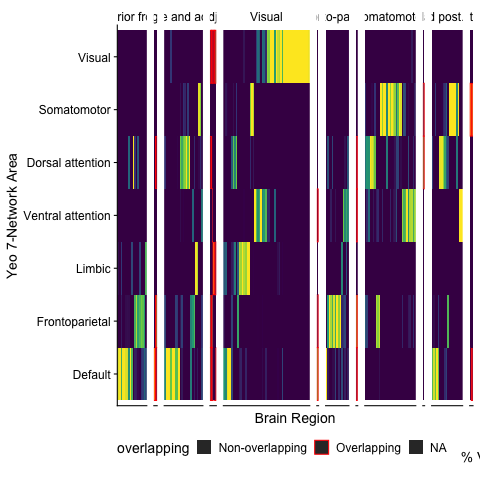

In [10]:
%%R -i merged_df,ocda_modules_glasser180_right

# region_order <- ocda_modules_glasser180_right %>% 
#        mutate(overlapping = factor(overlapping, levels=c("Overlapping", "Non-overlapping"))) %>% 
#        arrange(overlapping, module) %>% 
#        distinct(overlapping, Glasser_RH_ROI) %>%
#        pull(Glasser_RH_ROI)

region_order <- merged_df %>% 
    dplyr::select(-vertex_number) %>%
    filter(module != "Unassigned") %>%
    mutate(Yeo7_RH_ROI = ifelse(is.na(Yeo7_RH_ROI), "None", Yeo7_RH_ROI),
           overlapping = factor(overlapping, levels=c("Overlapping", "Non-overlapping"))) %>%
    filter(Yeo7_RH_ROI != "None") %>%
    group_by(module, Glasser_RH_ROI) %>% 
    mutate(num_voxels = n()) %>% 
    group_by(module, overlapping, Glasser_RH_ROI, Yeo7_RH_ROI) %>% 
    summarise(num_voxels_in_yeo7 = n(),
              prop_voxels_in_yeo7 = 100*num_voxels_in_yeo7/num_voxels) %>% 
    ungroup() %>%
    distinct() %>% 
    group_by(Glasser_RH_ROI, overlapping, module) %>% 
    filter(prop_voxels_in_yeo7 == max(prop_voxels_in_yeo7)) %>% 
       arrange(overlapping, Yeo7_RH_ROI) %>% 
       ungroup() %>%
       distinct(overlapping, Glasser_RH_ROI) %>%
       pull(Glasser_RH_ROI)

merged_df %>% 
    dplyr::select(-vertex_number) %>%
    filter(module != "Unassigned") %>%
    mutate(Yeo7_RH_ROI = ifelse(is.na(Yeo7_RH_ROI), "None", Yeo7_RH_ROI)) %>%
    filter(Yeo7_RH_ROI != "None") %>%
    group_by(module, Glasser_RH_ROI) %>% 
    mutate(num_voxels = n()) %>% 
    group_by(module, overlapping, Glasser_RH_ROI, Yeo7_RH_ROI) %>% 
    summarise(num_voxels_in_yeo7 = n(),
              prop_voxels_in_yeo7 = 100*num_voxels_in_yeo7/num_voxels) %>% 
    ungroup() %>%
    distinct() %>%
    complete(module, Glasser_RH_ROI, Yeo7_RH_ROI, fill=list(prop_voxels_in_yeo7=0)) %>% 
    semi_join(., ocda_modules_glasser180_right %>% dplyr::select(Glasser_RH_ROI, module)) %>%
    ungroup() %>% 
    mutate(Yeo7_RH_ROI = factor(Yeo7_RH_ROI, levels=rev(c("Visual", "Somatomotor", "Dorsal attention", "Ventral attention", "Limbic", "Frontoparietal", "Default"))),
           Glasser_RH_ROI = factor(Glasser_RH_ROI, levels=region_order)) %>%
    ggplot(data=., mapping=aes(y=Yeo7_RH_ROI, x=Glasser_RH_ROI, fill=prop_voxels_in_yeo7, color=overlapping)) +
    geom_tile(linewidth=0.5) +
    facet_grid(. ~ module, scales="free", space="free") +
    xlab("Brain Region") +
    ylab("Yeo 7-Network Area") +
    labs(fill="% Voxels in Network") +
    scale_color_manual(values=c("Overlapping"="red", "Non-overlapping"=NA), na.value=NA) +
    scale_fill_viridis_c() +
    theme(legend.position="bottom",
          strip.background = element_blank(),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank())

# ggsave("../Plots/Modules_vs_Yeo7_heatmap.svg", width=12, height=3.5, units="in")